# Problem 2: Linear Discriminative Analysis

## 2.2 implement GaussianDiscAnalysis class, fit the model with breast cancer data (using the first two features), plot the testing data and the decision boundary

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


class GaussianDiscAnalysis:
    """
    Fits a Linear Discriminant Analysis Model for binary class

    """

    def compute_phi(self, y):
        """
        calculate prior probability of positive class: P(Y=1)
        :param y: matrix of nx1
        :return: the prior probability
        """
        phi = np.count_nonzero(y)/len(y)
        # P(Y=0) = 1 - phi
        return phi

    def compute_mu(self, X, y):
        """
        compute Mu for the positive class and negative class
        :param X: matrix of nxd  (n is sample size and d is number of features)
        :param y: matrix of nx1
        :param cls: integer 0/1
        :return: matrix of 2xd with the first row being the mean of 0 class and the second row being the mean of class 1
        """
        # initialize the matrix Mu
        mu = np.zeros((2, X.shape[-1]), dtype=np.float32)
        
        # compute Mu using the formula
        mean_0 = np.mean(X[np.where(y == 0)], axis = 0)
        mu[0] = np.reshape(mean_0, (1,len(mean_0)))
        mean_1 = np.mean(X[np.where(y == 1)], axis = 0)
        mu[1] = np.reshape(mean_1, (1,len(mean_1))) 
        
        # TODO
        return mu

    def compute_sigma(self, X, y):
        """
        compute the common covariance matrix which is shared by the two classes
        :param X: matrix of nxd  (n is sample size and d is number of features)
        :param y: matrix of nx1
        :return:  dxd covariance matrix
        """
        # compute Mu first
        mu = self.mu
        
        # compute the covariance matrix using the formula
        X_0 = X[np.where(y == 0)]
        X_1 = X[np.where(y == 1)]
        cov = (np.dot((X_0 - mu[0]).T, (X_0 - mu[0])) + np.dot((X_1 - mu[1]).T, (X_1 - mu[1]))) / len(X)
        # TODO
        return cov

    def gaussian_p(self, x, cls):
        """
        Probability of X=x given y (Assume the conditional distribution is gaussian distribution)
        To get the inverse and determinant of an matrix you can use the module np.linalg
        :param x: 1D vector which is the feature vector for one observation
        :param cls: interger 0/1
        :return: probability density value of X=x|Y=cls
        """
        # TODO
        
        # compute d
        d = len(x)
        # compute the inverse of sigma
        inverse_sigma = np.linalg.inv(self.sigma)
        # compute determinant of sigma
        det_sigma = np.linalg.det(self.sigma)
        # compute the probability density value of X=x|Y=cls
        constant = 1 / ((2 * np.pi) ** (d / 2) * det_sigma ** (1/2))
        
        if cls == 0:
            this_mu = self.mu[0]
        else:
            this_mu = self.mu[1]
        return constant * np.exp( -1/2 * np.dot(np.dot((np.reshape(x, (1, d)) - this_mu), inverse_sigma), (np.reshape(x, (1, d)) - this_mu).T)) 

    def fit(self, X, y):
        """Computes mean, covariance and proabilities of y (phi)"""
        self.d = X.shape[1]
        # the prior probability of Y=1
        self.phi = self.compute_phi(y)
        # mean of X for each class
        self.mu = self.compute_mu(X, y)
        # the common covariance matrix
        self.sigma = self.compute_sigma(X, y)

    def predict(self, X):
        """
        make prediction based on P(Y|X).
        You can effectively compare P(Y=1)*P(X|Y=1) v.s. P(Y=0)*P(X|Y=0)
        :param X: 2D vector which each row representing a data point
        :return: 1D vector which each element being 0/1
        """
        # TODO
        
        # for each data point, calculate P(Y=1)*P(X|Y=1) and P(Y=0)*P(X|Y=0)
        # if P(Y=1)*P(X|Y=1) > P(Y=0)*P(X|Y=0), then y is predicted to be 1
        # else, y is predicted to be 0
            
        return [int(self.phi * self.gaussian_p(x, 1) > (1 - self.phi) * self.gaussian_p(x, 0)) for x in X]


In [2]:
breast_cancer = load_breast_cancer()
data = np.array(breast_cancer.data)
label = np.array(breast_cancer.target)
data = MinMaxScaler().fit_transform(data)

In [3]:
# Split the training set and test set (only keep the first two features )
train_data, test_data, train_label, test_label = train_test_split(data[:, :2], label, test_size=1 / 4, random_state=0)

In [4]:
# fit the model using the training data
gda = GaussianDiscAnalysis()
gda.fit(train_data, train_label)

In [5]:
# get predictions for the test data, print out the accuracy score
test_pred = gda.predict(test_data)
print('the accuracy score is {}'.format(accuracy_score(test_label, test_pred)))

the accuracy score is 0.8951048951048951


coefficients of linear decision boundary: intercept = 1.4311620254386697, slope = -2.7373690432520297


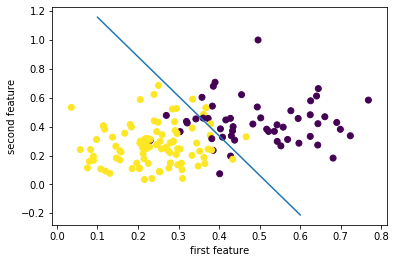

In [6]:
""""P2.2 plot the data and the decision boundary"""
# data visualization
# plot the testing data (x axis: first feature, y axis: second feature), use different colors for the two classes
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_label)
plt.xlabel("first feature")
plt.ylabel("second feature")
# on the same figure, plot the decision boundary
theta_T = np.dot((gda.mu[0] - gda.mu[1]), np.linalg.inv(gda.sigma))
theta_0 = (np.dot(np.dot(gda.mu[0], 1 / 2 * np.linalg.inv(gda.sigma)), gda.mu[0].T) - np.dot(np.dot(gda.mu[1], 1 / 2 * np.linalg.inv(gda.sigma)), gda.mu[1].T)) + np.log(gda.phi/(1-gda.phi))
x = np.linspace(0.1, 0.6, 1000)
y = (theta_0 - theta_T[0] * x) / theta_T[1]  
plt.plot(x, y)
# print out the intercept and the slope of the linear decision boundary
print("coefficients of linear decision boundary: intercept = %s, slope = %s"%((theta_0 / theta_T[1]) , (- theta_T[0] / theta_T[1])))